<a href="https://colab.research.google.com/github/zzaeyun/ESAA23_1/blob/main/%ED%85%90%EC%84%9C%ED%94%8C%EB%A1%9C_182to200.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **04 위성 이미지 분류**
###**4-1 텐서플로 데이터셋 로드**
**EuroSAT**
- 인공위성에서 지표면을 촬영한 이미지와 토지이용분류(Land Use and Land Cover) 값이 정리되어 있음
- EU의 코페르니쿠스 지구 관측 프로그램에 의해 제공되는 공용 데이터셋인 Sentinel-2 위성이 관측한 이미지를 기반으로 함
- 총 27000장의 위성 사진과 10개의 토지이용분류 값이 매칭되어 제공

In [ ]:
import tensorflow as tf
import numpy as np
import json
import matplotlib,pylab as plt

import tensorflow_datasets as tfds

- '(훈련 셋, 검증 셋), 메타 정보' 순으로 분리되어 반환
  - with_info: 메타 정보 포함 여부
- 이미지는 (64, 64, 3) 형태

In [ ]:
DATA_DIR='/'

(train_ds, valid_ds), info=tfds.load('eurosat/rgb', split=['train[:80%]', 'train[80%:]'],
                                     shuffle_files=True,
                                     as_supervised=True,
                                     with_info=True,
                                     data_dir=DATA_DIR)

print(train_ds)
print(valid_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


메타정보 출력

In [ ]:
print(info)

tfds.core.DatasetInfo(
    name='eurosat',
    full_name='eurosat/rgb/2.0.0',
    description="""
    EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
    bands and consisting of 10 classes with 27000 labeled and
    geo-referenced samples.
    
    Two datasets are offered:
    - rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
    - all: Contains all 13 bands in the original value range (float32).
    
    URL: https://github.com/phelber/eurosat
    """,
    config_description="""
    Sentinel-2 RGB channels
    """,
    homepage='https://github.com/phelber/eurosat',
    data_path='/eurosat/rgb/2.0.0',
    file_format=tfrecord,
    download_size=89.91 MiB,
    dataset_size=89.50 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=string),
        'image': Image(shape=(64, 64, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label')

show_examples: 샘플 이미지를 메타 정보인 분류 레이블과 함께 화면에 출력

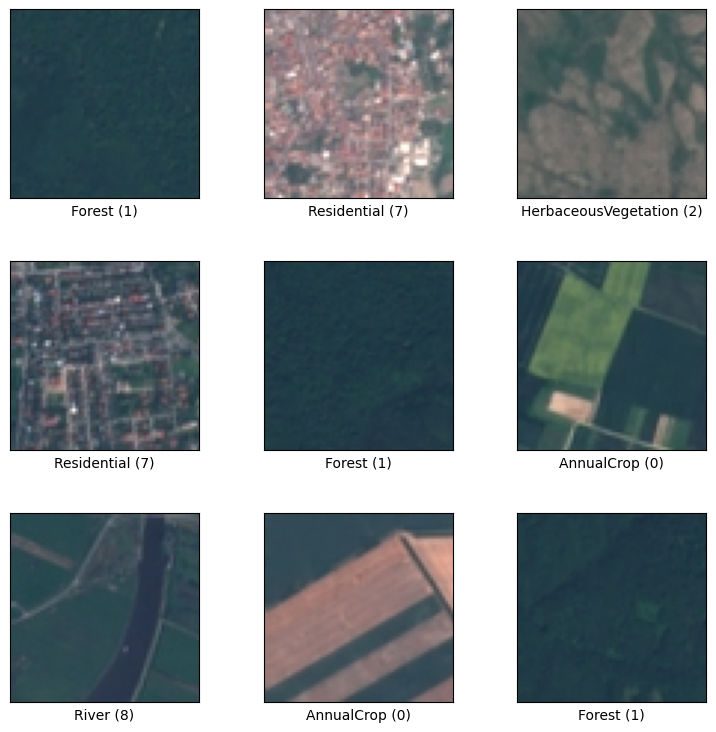

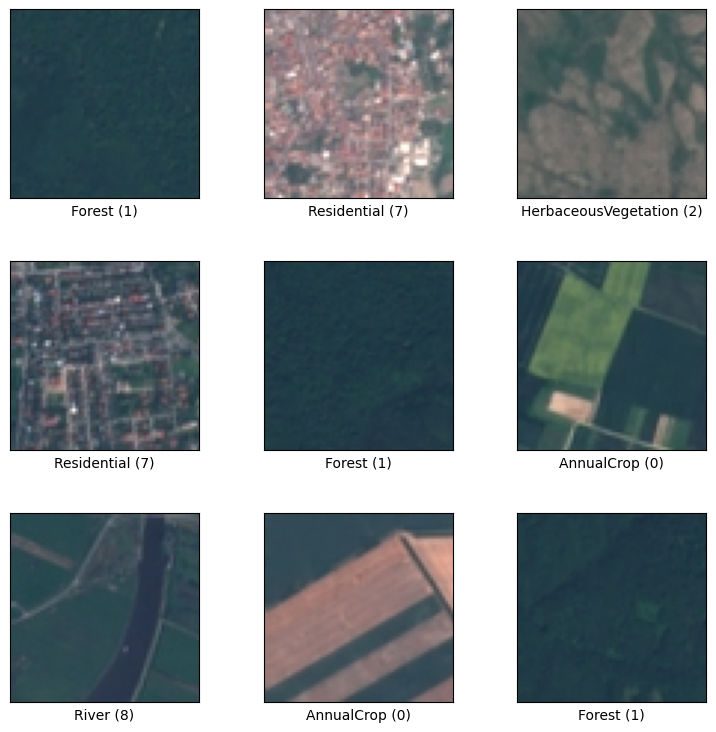

In [ ]:
tfds.show_examples(train_ds,info)

as_dataframe: 샘플 이미지 10개를 화면에 표시

,image,label
0,,5 (Pasture)
1,,7 (Residential)
2,,0 (AnnualCrop)
3,,1 (Forest)
4,,0 (AnnualCrop)
5,,2 (HerbaceousVegetation)
6,,9 (SeaLake)
7,,8 (River)
8,,2 (HerbaceousVegetation)
9,,9 (SeaLake)

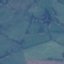
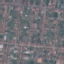
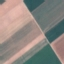
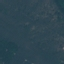
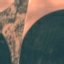
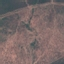
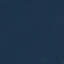
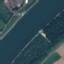
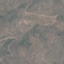
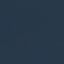

In [ ]:
tfds.as_dataframe(valid_ds.take(10), info)

토지이용분류에 해당하는 정답 클래스 개수는 10개
- 0은 경작지(AnnualCrop)
- 9는 바다/호수(SeaLake)

In [ ]:
NUM_CLASSES=info.features['label'].num_classes
print(NUM_CLASSES)

10


클래스를 나타내는 숫자 레이블을 메타 데이터의 문자열로 변환 가능
- 메타데이터의 features 값 중 label에 대항하는 메타 정보에 int2str() 메소드 적용

In [ ]:
print(info.features['label'].int2str(6))

PermanentCrop


### **4-2 데이터 전처리**
텐서플로 데이터셋: 전처리 과정이 매우 쉬움, 텐서 연산을 효율적으로 처리할 수 있는 최적화 지원
- 함수 사용 이전 전처리
  - cast 함수: 자료형을 float32로 변환
  - preprocess_data 함수: 0~255 범위의 픽셀 값을 255로 나누어 정규화
- map 함수: 사용자 정의 함수를 매핑하여 텐서플로 데이터셋에 적용하는 메소드
  - num_parallel_calls 옵션을 오토튠(AUTOTUNE)으로 지정하면 텐서플로 병렬연산 처리를 자동으로 최적화
- shuffle() 메소드 : 순서를 랜덤하게 섞어줌
  - 모델의 일반화된 성능을 높이기 위해 훈련 데이터셋에서 미니 배치를 생성할 때 입력 순서에 무작위성 부여
  - BUFFER_SIZE:1000, BATCH_SIZE:64 -> 1000개의 데이터를 가져와서 섞고 64개의 데이터를 랜덤하게 선택하여 하나의 배치를 구성
- prefetch() 메소드: 훈련을 진행하는 동안 다음에 입력할 데이터를 불러와 미리 전처리를 하도록 시스템 조율, 모델 훈련 시간 단축


In [ ]:
BATCH_SIZE=64
BUFFER_SIZE=1000

def preprocess_data(image, label):
  image=tf.cast(image,tf.float32)/255
  return image, label

train_data=train_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
valid_data=valid_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)

train_data=train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_data=valid_data.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
print(train_data)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


### **4-3 모델 훈련 및 검증**
배치 정규화, 합성곱, 풀링 레이어로 구성된 유닛 2개 연결하고 Dense 레이어와 Dropout으로 구성된 최종 분류기를 갖는 딥러닝 모델을 생성

In [ ]:
from re import M
def build_model():
  model=tf.keras.Sequential([
      #Convolution 층
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(32,(3,3), padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D((2,2)),
      
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(64,(3,3), padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D((2,2)),

      #Classifier 출력층
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128,activation='relu'),
      tf.keras.layers.Dropout(0,3),
      tf.keras.layers.Dense(64,activation='relu'),
      tf.keras.layers.Dropout(0,3),
      tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')

  ])
  return model

model=build_model()

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history=model.fit(train_data,
                  validation_data=valid_data,
                  epochs=10)

Epoch 1/10
338/338 [==============================] - 235s 684ms/step - loss: 1.0282 - accuracy: 0.6456 - val_loss: 1.3022 - val_accuracy: 0.5404
Epoch 2/10
338/338 [==============================] - 220s 651ms/step - loss: 0.6618 - accuracy: 0.7692 - val_loss: 0.6220 - val_accuracy: 0.7789
Epoch 3/10
338/338 [==============================] - 219s 649ms/step - loss: 0.5331 - accuracy: 0.8117 - val_loss: 0.5532 - val_accuracy: 0.8039
Epoch 4/10
338/338 [==============================] - 218s 645ms/step - loss: 0.4347 - accuracy: 0.8444 - val_loss: 0.4385 - val_accuracy: 0.8513
Epoch 5/10
338/338 [==============================] - 206s 609ms/step - loss: 0.3469 - accuracy: 0.8788 - val_loss: 0.4375 - val_accuracy: 0.8474
Epoch 6/10
338/338 [==============================] - 215s 637ms/step - loss: 0.2930 - accuracy: 0.8963 - val_loss: 0.4573 - val_accuracy: 0.8519
Epoch 7/10
338/338 [==============================] - 199s 589ms/step - loss: 0.2195 - accuracy: 0.9244 - val_loss: 0.5558 -

모델이 10epoch 까지는 빠른 속도로 훈련이 진행되면서 손실함수가 급격히 감소하지만 이후에는 과대적합 경향을 나타냄

In [ ]:
def plot_loss_acc(history, epoch):

    loss, val_loss = history.history['loss'], history.history['val_loss']
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(range(1, epoch + 1), loss, label='Training')
    axes[0].plot(range(1, epoch + 1), val_loss, label='Validation')
    axes[0].legend(loc='best')
    axes[0].set_title('Loss')

    axes[1].plot(range(1, epoch + 1), acc, label='Training')
    axes[1].plot(range(1, epoch + 1), val_acc, label='Validation')
    axes[1].legend(loc='best')
    axes[1].set_title('Accuracy')

    plt.show()

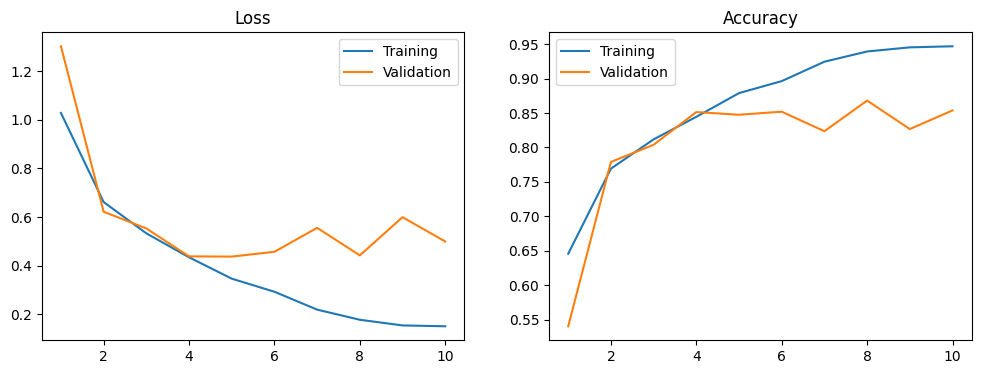

In [ ]:
plot_loss_acc(history, 10)

### **4-4 데이터 증강(Data Augmentation)**
데이터 증강 기법
- 이미지 분류 문제에서 과대적합을 해소
- 모델의 일반화된 Robust한 성능을 확보
- 이미지 데이터에 여러 가지 변형을 주어 훈련 데이터의 다양성을 확보하는 방식

Text(0.5, 1.0, 'River')

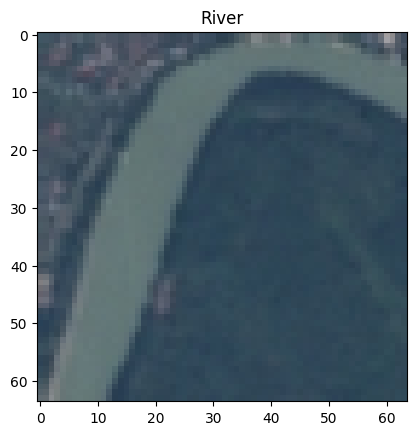

In [ ]:
image_batch, label_batch=next(iter(train_data.take(1)))

image=image_batch[0]
label=label_batch[0].numpy()

plt.imshow(image)
plt.title(info.features['label'].int2str(label))

In [ ]:
#데이터 증강 전후를 비교하는 시각화 함수
def plot_augmentation(original, augmented):
  fig, axes=plt.subplots(1,2, figsize=(12,4))
  axes[0].imshow(original)
  axes[0].set_title('Original')
  axes[1].imshow(augmented)
  axes[1].set_title('Augmented')

  plt.show()

tf.image 모듈의 flip_left_right: 좌우 방향으로 뒤집는 방법

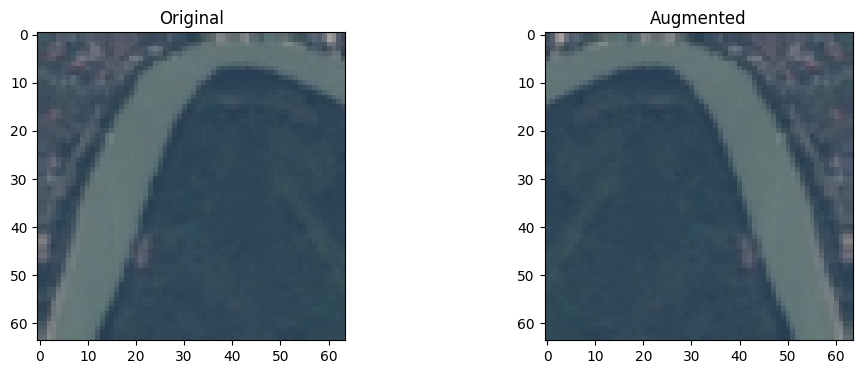

In [ ]:
lr_flip=tf.image.flip_left_right(image)
plot_augmentation(image, lr_flip)

flip_up_down: 상하 방향

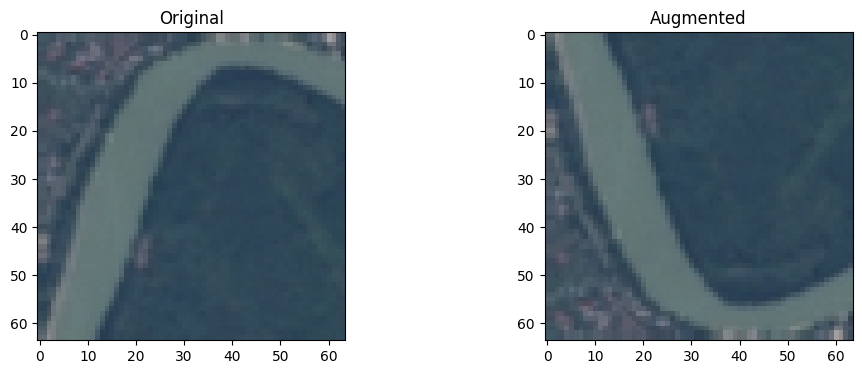

In [ ]:
up_flip=tf.image.flip_up_down(image)
plot_augmentation(image, up_flip)

rot90: 반시계 방향으로 90도 회전

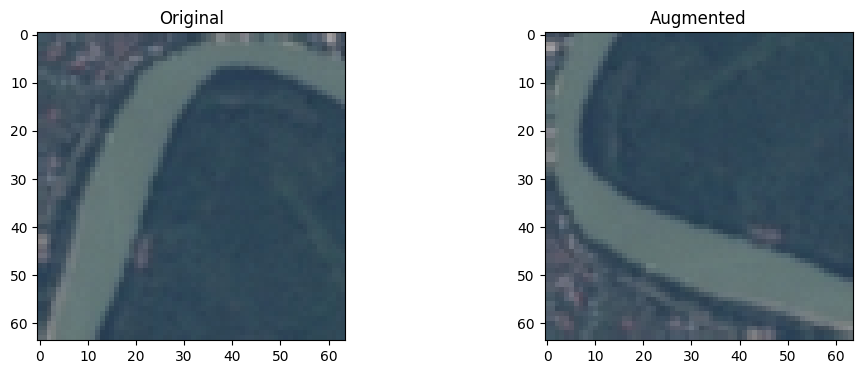

In [ ]:
rotate90=tf.image.rot90(image)
plot_augmentation(image, rotate90)

transpose: 이미지 텐서 행렬의 행과 열의 위치를 바꿈

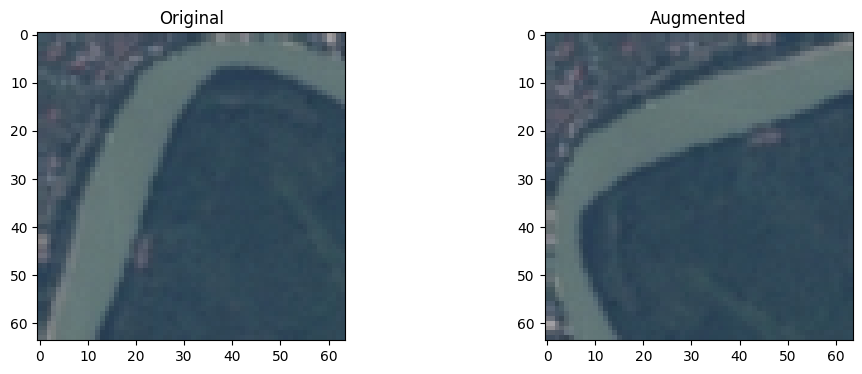

In [ ]:
transpose=tf.image.transpose(image)
plot_augmentation(image, transpose)

central_crop: 이미지의 중심에서 일정 부분을 잘라내는 방법

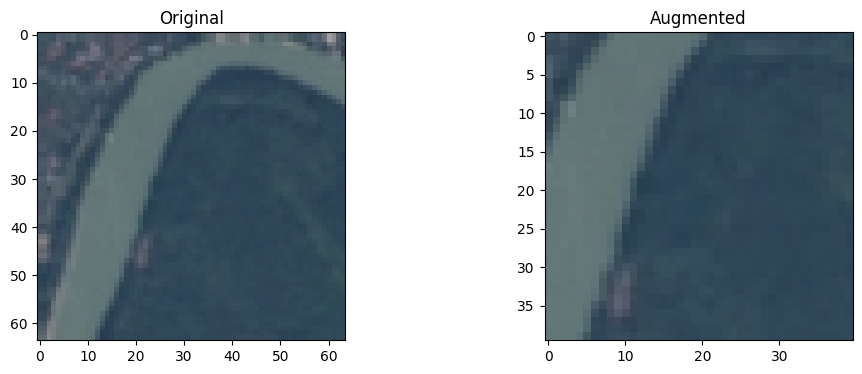

In [ ]:
crop1=tf.image.central_crop(image, central_fraction=0.6)
plot_augmentation(image, crop1)

- resize_with_crop_or_pad: 원본 이미지의 크기를 키움
- random_crop: 이미지를 원본 크기와 같게 자르면 원본 이미지가 상하좌우 랜덤한 방향으로 시프트 이동

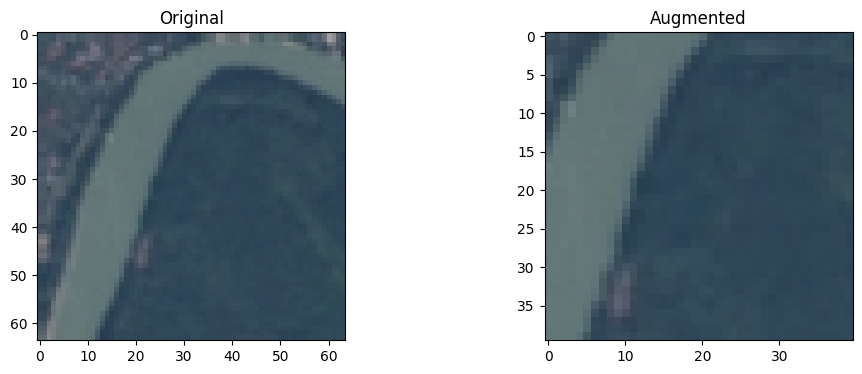

In [ ]:
img=tf.image.resize_with_crop_or_pad(image, 64+20, 64+20)
crop2=tf.image.random_crop(img, size=[64,64,3])
plot_augmentation(image, crop1)

adjust_brightness: 이미지의 밝기 조정

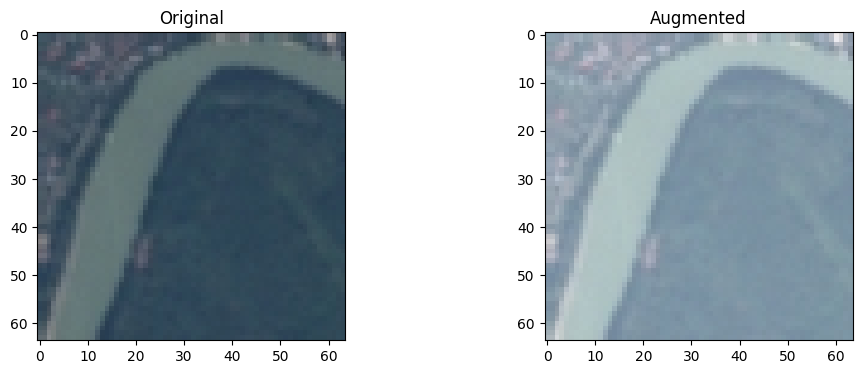

In [ ]:
brightness=tf.image.adjust_brightness(image, delta=0.3)
plot_augmentation(image, brightness)

adjust_saturation: 이미지의 채도 변경

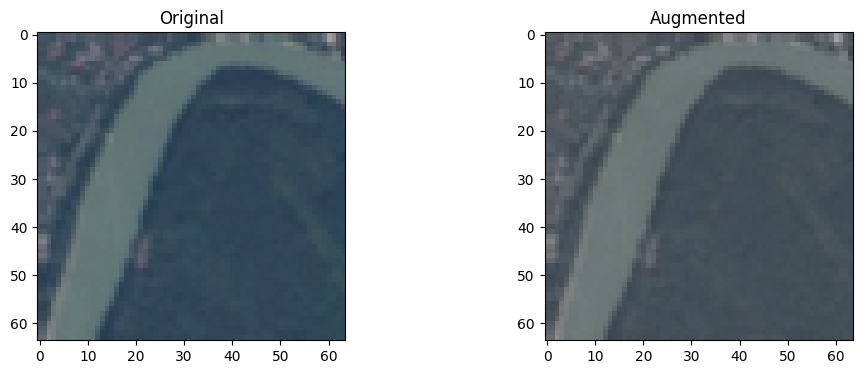

In [ ]:
saturation=tf.image.adjust_saturation(image, saturation_factor=0.5)
plot_augmentation(image, saturation)

adjust_contrast: 이미지의 대비(contrast) 조정

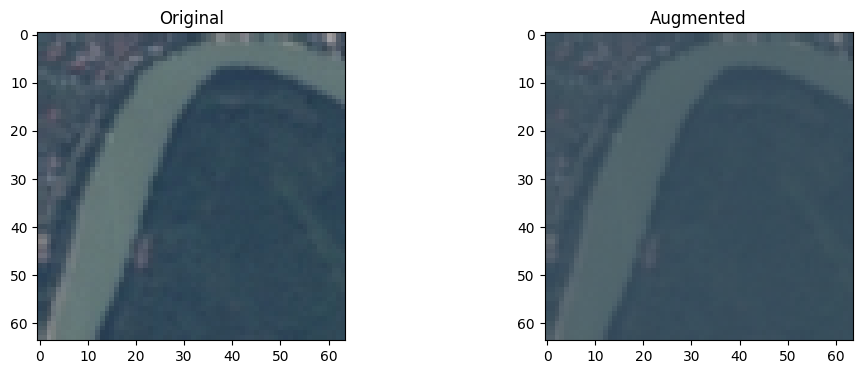

In [ ]:
contrast=tf.image.adjust_contrast(image,contrast_factor=0.5)
plot_augmentation(image, contrast)

데이터 증강 및 전처리를 수행하는 data_augmentation 함수 정의

In [ ]:
def data_augmentation(image, label):
  image=tf.image.random_flip_left_right(image)
  image=tf.image.random_flip_up_down(image)
  image=tf.image.random_brightness(image, max_delta=0.3)
  image=tf.image.random_crop(image, size=[64,64,3])

  image=tf.cast(image, tf.float32)/255

  return image, label

train_aug=train_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
valid_aug=valid_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

train_aug=train_aug.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_aug=valid_aug.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

print(train_aug)
print(valid_aug)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [ ]:
aug_model=build_model()

aug_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

aug_history=aug_model.fit(train_aug,
                  validation_data=valid_aug,
                  epochs=10)

In [ ]:
plot_loss_acc(aug_history, 10)

### **4-5 ResNet 사전 학습 모델**
사전에 방대한 이미지로 훈련을 받은 딥러닝 모델의 구조와 가중치를 그대로 가져오고, 모델 끝단에 위치하는 Top 층에 위성 이미지를 분류할 수 있는 최종분류기를 추가: 전이 학습(Trnsfer Learning)

<br>

ResNet50V2 버전
- input_shape: (64,64,3)
  - 모델 입력 크기는 (224, 224, 3): 케라스에서 우리가 지정한 크기로 맞추어 줄여줌
- classes: 10
- include_top=False: 기존 Top 층을 제거

In [ ]:
from tensorflow.keras.applications import ResNet50V2

pre_trained_base=ResNet50V2(include_top=False,
                            weights='imagenet',
                            input_shape=[64,64,3])

pre_trained_base.trainable=False

from tensorflow.python.keras.utils.vis_utils import plot_model
plot_model(pre_trained_base, show_shapes=True, show_layer_names=True)

In [ ]:
def build_trainsfer_classifier():
  model=tf.keras.Sequential([
      pre_trained_base,
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128,activation='relu'),
      tf.keras.layers.Dropout(0,3),
      tf.keras.layers.Dense(64,activation='relu'),
      tf.keras.layers.Dropout(0,3),
      tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
  ])

  return model

tc_model=build_trainsfer_classifier()
tc_model.summary()